In [35]:
# 1. Importar librerías
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

# Bibliotecas para procesamiento de imágenes
import cv2
from PIL import Image

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
# 2. Comprobar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [37]:
# 3. Configuración de hiperparámetros
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
IMG_SIZE = 224

# 4. Transformaciones para preprocesamiento
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # si es RGB usa 3 valores
])

# 5. Cargar datos
DATA_DIR = '../data/Brain_Data_Organised'
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)



In [38]:
# 6. Dividir en train y validación (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [39]:
# 7. Red neuronal
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 224),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(224, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

model = SimpleCNN(num_classes=len(full_dataset.classes)).to(device)

In [40]:
# 8. Loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [41]:
# 9. Entrenamiento
train_loss_values = []
val_loss_values = []
train_acc_values = []
val_acc_values = []

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)

    train_loss /= len(train_dataset)
    train_accuracy = train_correct.double() / len(train_dataset)

    # Validación
    model.eval()
    val_loss, val_correct = 0.0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_loss /= len(val_dataset)
    val_accuracy = val_correct.double() / len(val_dataset)

    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    train_acc_values.append(train_accuracy.cpu())
    val_acc_values.append(val_accuracy.cpu())

    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1/10: Train Loss: 1.0512, Val Loss: 0.5002, Train Acc: 0.6405, Val Acc: 0.7585
Epoch 2/10: Train Loss: 0.4131, Val Loss: 0.3318, Train Acc: 0.8105, Val Acc: 0.8403
Epoch 3/10: Train Loss: 0.2191, Val Loss: 0.2236, Train Acc: 0.9080, Val Acc: 0.9002
Epoch 4/10: Train Loss: 0.1243, Val Loss: 0.1601, Train Acc: 0.9525, Val Acc: 0.9381
Epoch 5/10: Train Loss: 0.0815, Val Loss: 0.1322, Train Acc: 0.9695, Val Acc: 0.9481
Epoch 6/10: Train Loss: 0.0389, Val Loss: 0.1060, Train Acc: 0.9875, Val Acc: 0.9621
Epoch 7/10: Train Loss: 0.0261, Val Loss: 0.1278, Train Acc: 0.9930, Val Acc: 0.9521
Epoch 8/10: Train Loss: 0.0205, Val Loss: 0.1096, Train Acc: 0.9940, Val Acc: 0.9681
Epoch 9/10: Train Loss: 0.0146, Val Loss: 0.1268, Train Acc: 0.9950, Val Acc: 0.9541
Epoch 10/10: Train Loss: 0.0145, Val Loss: 0.1172, Train Acc: 0.9970, Val Acc: 0.9601


In [42]:
# 10. Guardar modelo
torch.save(model.state_dict(), "cnn_pytorch.pth")

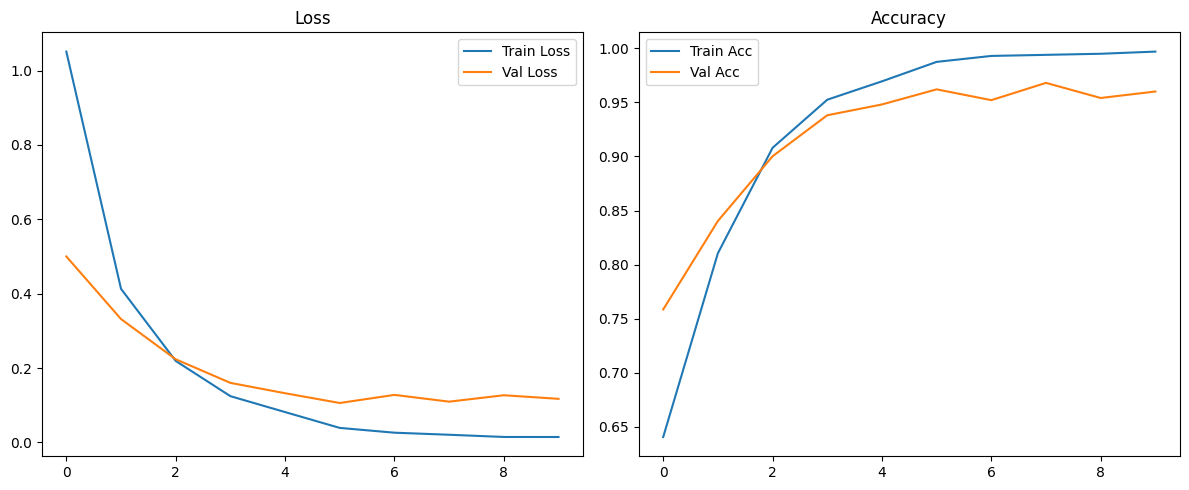

In [43]:
# 11. Gráficas

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label="Train Loss")
plt.plot(val_loss_values, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label="Train Acc")
plt.plot(val_acc_values, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


--- Evaluación en conjunto de validación ---
Accuracy:  0.9601
Precision: 0.9570
Recall:    0.9368
F1 Score:  0.9468
AUC:       0.9926

Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97       311
      Stroke       0.96      0.94      0.95       190

    accuracy                           0.96       501
   macro avg       0.96      0.96      0.96       501
weighted avg       0.96      0.96      0.96       501



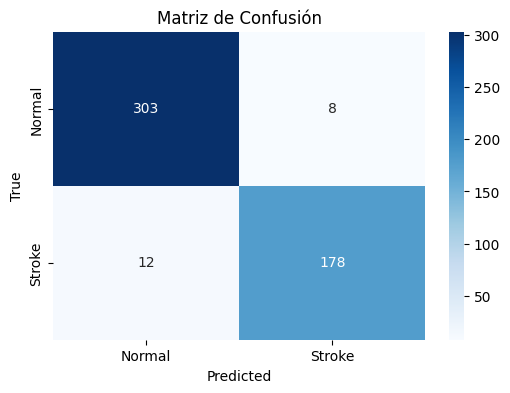

In [44]:
# Evaluación
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])

print("\n--- Evaluación en conjunto de validación ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}\n")

print("Reporte de clasificación:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()




--- Evaluación en conjunto de validación ---
Accuracy:  0.9301
Precision: 0.8814
Recall:    0.9344
F1 Score:  0.9072
AUC:       0.9814

Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       0.96      0.93      0.94       318
      Stroke       0.88      0.93      0.91       183

    accuracy                           0.93       501
   macro avg       0.92      0.93      0.93       501
weighted avg       0.93      0.93      0.93       501



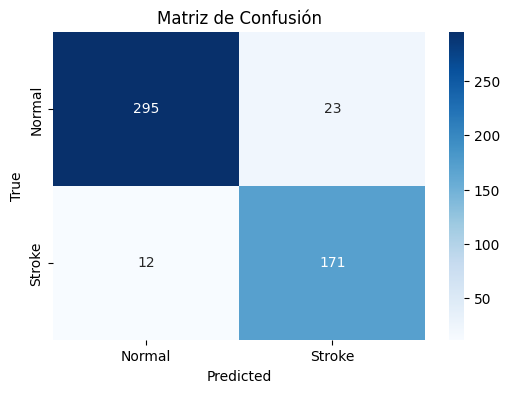

In [ ]:
# Evaluación
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])

print("\n--- Evaluación en conjunto de validación ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}\n")

print("Reporte de clasificación:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()



## Explicación del Modelo CNN y Entrenamiento
### Arquitectura de la CNN
El modelo actual es una CNN simple con las siguientes características:

1. Bloque Convolucional :
   
   - Primera capa: 3 canales de entrada → 32 filtros (3x3)
   - Activación ReLU y MaxPooling (2x2)
   - Segunda capa: 32 → 64 filtros (3x3)
   - Activación ReLU y MaxPooling (2x2)
2. Bloque Fully Connected :
   
   - Aplanamiento de características
   - Capa densa: 64*(IMG_SIZE//4)*(IMG_SIZE//4) → 128 neuronas
   - Dropout (0.5) para regularización
   - Capa de salida: 128 → 2 clases (Normal/Stroke)
### Proceso de Entrenamiento
El entrenamiento sigue estos pasos:

1. Preparación de Datos :
   
   - Carga de imágenes desde Brain_Data_Organised
   - Redimensionamiento a 128x128 píxeles
   - Normalización de valores de píxeles
   - División 80/20 para entrenamiento/validación
2. Bucle de Entrenamiento :
   
   - Forward pass: Cálculo de predicciones
   - Cálculo de pérdida con CrossEntropyLoss
   - Backward pass: Cálculo de gradientes
   - Actualización de pesos con el optimizador Adam
   - Evaluación en conjunto de validación
3. Evaluación :
   
   - Métricas: Accuracy, Precision, Recall, F1-Score, AUC
   - Matriz de confusión para visualizar resultados
## Conclusión
El modelo actual muestra un buen rendimiento, pero hay margen de mejora. Las modificaciones sugeridas en el optimizador, arquitectura, aumento de datos y regularización pueden ayudar a mejorar las métricas de rendimiento. Recomiendo implementar estos cambios de forma incremental, evaluando el impacto de cada modificación para determinar qué combinación ofrece los mejores resultados para este problema específico de clasificación de imágenes cerebrales.

La elección entre Adam y SGD con momentum dependerá de sus prioridades: si necesita una convergencia rápida, Adam puede ser preferible; si busca mejor generalización, SGD con momentum podría ser más adecuado. En cualquier caso, el aumento de datos y la regularización adecuada serán fundamentales para mejorar el rendimiento del modelo en este tipo de tarea médica.